In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import socket
import struct
from datetime import datetime
from scipy.special import factorial

In [3]:
pos_df = pd.read_csv('data/results_pos.csv')
pos_df['health'] = 1
neg_df = pd.read_csv('data/results_neg.csv')
neg_df['health'] = 0
df = pd.concat([pos_df, neg_df])
ip = pd.read_csv('data/interface_ip.csv')
ip = ip.drop('Unnamed: 0',1)

In [4]:
def convert_time(ts):
    
    # convert into a datetime obj with microsecs
    dt = datetime.strptime(ts, '%Y-%m-%dT%H:%M:%S.%fZ')
    
    # change to epoch time
    ep = ((dt-datetime(1970,1,1)).total_seconds())
    
    # to check if time is coverted correctly 
    #ts = datetime.utcfromtimestamp(ep)
    #datetime.strftime(ts, '%Y-%m-%dT%H:%M:%S.%fZ')
    return ep 

def log_entropy(x):
    f = lambda x,y: x*y
    num = np.log(factorial(sum(x)))
    denom = np.log(reduce(f, factorial(x)))
    return num - denom

In [5]:
x = list(df)
f = []
for i in range(len(x)):
    if 'generic_counters' in x[i]: 
        f.append(x[i][25:])
    elif 'delta' in x[i]:
        f.append(x[i][8:])
    elif '@' in x[i]: # @timehost
        f.append(x[i][1:])
    elif 'InterfaceName' in x[i]: #change interface
        f.append(x[i][12:21].lower())
    else:
        f.append(x[i])

df = df.rename(columns=dict(zip(x,f)))

In [6]:
df = pd.merge(df,ip,how='inner', on=['hostname', 'interface'])

In [7]:
df['epoch_time'] = df['timestamp'].apply(convert_time)

In [8]:
df = df.sort_values('epoch_time')
df = df.drop('timestamp',1)
#df = df.set_index('epoch_time')

In [9]:
cols = list(df)
cols = cols[-1:] + cols[:-1]
df = df[cols]

In [10]:
df = df.drop('interface',1)

In [11]:
# create dummy variables for each hostname
dummy_host = pd.get_dummies(df['hostname'])

In [12]:
df = dummy_host.join(df)

In [13]:
#df = df.drop('hostname',1)

In [14]:
#dummy_ip = pd.get_dummies(df['ip'])
#df = df.join(dummy_ip)

In [15]:
df['log_bytesSent'] = np.log(df.BytesSent)
df['log_bytesReceived'] = np.log(df.BytesReceived)
df['log_packetsSent'] = np.log(df.PacketsSent)
df['log_packetsReceived'] = np.log(df.PacketsSent)

# replace all inf with NaN as there are 0s 
df = df.replace([np.inf, -np.inf], np.nan).dropna()

count    43200.000000
mean        17.118118
std          6.072831
min          5.204007
25%         14.438651
50%         16.934893
75%         18.955281
max         30.273499
Name: log_bytesSent, dtype: float64


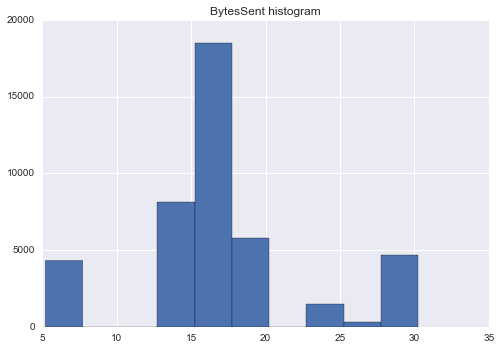

In [16]:
print df.log_bytesSent.describe()
plt.hist((df.log_bytesSent))
plt.title('BytesSent histogram')

count    43200.000000
mean        18.442593
std          4.781947
min         12.775132
25%         15.106546
50%         17.025860
75%         19.024522
max         30.273926
Name: log_bytesReceived, dtype: float64


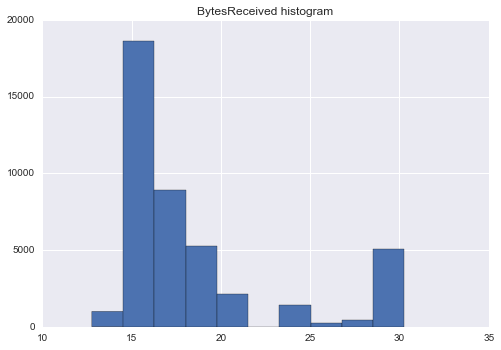

In [17]:
print df.log_bytesReceived.describe()
plt.hist((df.log_bytesReceived))
plt.title('BytesReceived histogram')

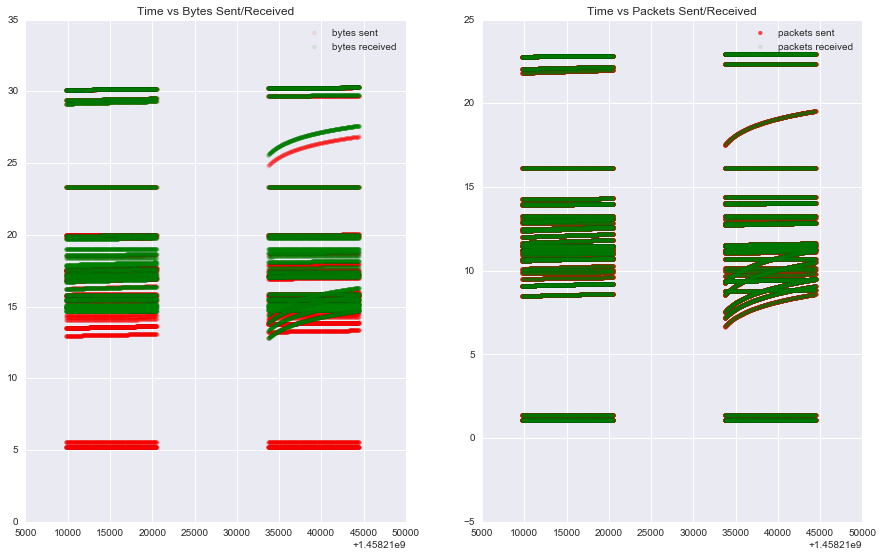

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,9))
ax[0].scatter(df.epoch_time,(df.log_bytesSent),alpha=0.1, color='r', s=15, label='bytes sent')
ax[0].scatter(df.epoch_time,(df.log_bytesReceived),alpha=0.1 ,color='g', s=15, label='bytes received')
ax[1].scatter(df.epoch_time,df.log_packetsSent,alpha=0.7, color='r', s=15, label='packets sent')
ax[1].scatter(df.epoch_time,df.log_packetsReceived,alpha=0.1 ,color='g', s=15, label='packets received')
ax[0].legend()
ax[1].legend()
ax[0].set_title('Time vs Bytes Sent/Received')
ax[1].set_title('Time vs Packets Sent/Received')

We show two plots of time vs. bytes sent/received and time vs. packets sent/received. The first graph does not indicate of any patterns except that bytes received is higher than sent. There is also a missing time period between 20000 - 35000. Why is that?

For packets, we observe that its fairly equal. Perhaps an importance feature is a delta between the two. Let us create that the feature.

1458231000.0 1458243000.0


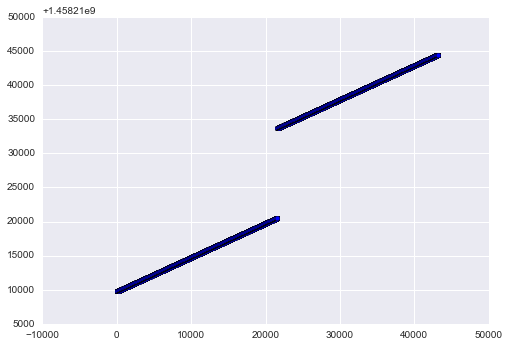

In [19]:
#df[(df['epoch_time'] > 21000+1.45821e+09) & (df['epoch_time'] < 33000+1.45821e+09)]
plt.scatter(range(len(df.epoch_time)), df.epoch_time)
print 21000+1.45821e+09, 33000+1.45821e+09

In [20]:
# use the raw as the log version will give 0s
df['delta_packets'] = df.PacketsReceived - df.PacketsSent

(array([  4320.,      0.,    202.,   7082.,  13630.,  10046.,   2880.,
           105.,    255.,   4680.]),
 array([  1.09861229,   3.28398238,   5.46935247,   7.65472257,
          9.84009266,  12.02546275,  14.21083284,  16.39620293,
         18.58157303,  20.76694312,  22.95231321]),
 <a list of 10 Patch objects>)

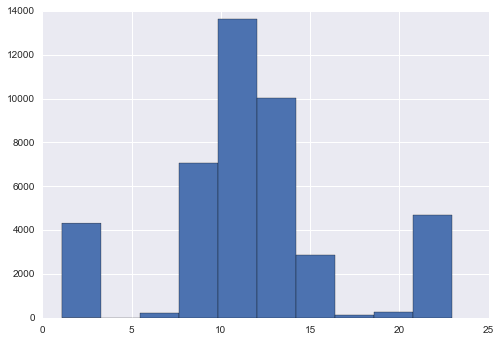

In [21]:
plt.hist(df.log_packetsReceived)

In [22]:
# convert IP address from string to its 32bit representation 
# note on apply: we apply on a series df['ip'] cus the function applies on single values
df['ip_int'] = df['ip'].apply(lambda x: struct.unpack("!L", socket.inet_aton(x))[0])

In [23]:
# normalise...use apply on a dataframe
df[['MulticastPacketsSent_norm', 'MulticastPacketsReceived_norm']] = df[['MulticastPacketsSent', 'MulticastPacketsReceived']].apply(lambda x: x - x.mean() / x.std())

In [24]:
r = df[['PacketsReceived', 'PacketsSent', 'BytesReceived', 'BytesSent']].apply(lambda x: np.log(x - x.mean() / x.std()))
c = ['log_packetsReceived_norm', 'log_packetsSent_norm', 'log_BytesReceived_norm', 'log_BytesSent_norm']
rn = dict(zip(list(r), c))
r = r.rename(columns=rn)
df = df.join(r)

In [25]:
# feature engineer some time stuff
# df['delta_DataTime_DiscontinuityTime']= df.LastDataTime - df.LastDiscontinuityTime
# df['delta_epoch_lastDataTime'] = df.LastDataTime - df.epoch_time

In [26]:
# create a ratio of packets/ broadcast packets
df['ratio_broadcast_packetsent'] = np.log(df.BroadcastPacketsSent) / df.log_packetsSent_norm
df['ratio_broadcast_packetrec'] = np.log(df.BroadcastPacketsReceived) / df.log_BytesReceived_norm
df[df == -np.Inf] = np.NaN
df = df.fillna(0)

In [27]:
# df = df.drop('LastDiscontinuityTime',1)
# df = df.drop('ip',1)
# df = df.drop('hostname', 1)
df.to_csv('data/final.csv')

In [28]:
# f = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
#                           'foo', 'bar', 'foo', 'foo'],
#                    'B' : ['one', 'one', 'two', 'three',
#                          'two', 'two', 'one', 'three'],
#                    'C' : [2,3,4,5,6,9,1,2] , 'D' : [1,2,3,4,5,6,7,9]})

# #f = pd.DataFrame({'C' : [2,3,4,5,6,9,1,2] , 'D' : [1,2,3,4,5,6,7,9]})
# z = lambda x: (x - x.mean()) / x.std()
# #f.groupby('A').transform(lambda x: x)
# f['c2'] = f['C'].apply(lambda x: x*1.0)
# f['d2'] = f['D'].apply(lambda x: x*1.0)
# f[['C']].apply(z)

In [29]:
# df = df.drop(['ThrottledPacketsReceived', 'CRCErrors', 'SecondsSinceLastClearCounters', \
#                       'OutputQueueDrops', 'OutputUnderruns', 'InputErrors', 'AvailabilityFlag', \
#                       'InputDrops', 'OutputDrops', 'OutputBuffersSwappedOut', 'Resets', 'InputAborts', \
#                       'GiantPacketsReceived', 'FramingErrorsReceived', 'OutputBufferFailures', \
#                       'CarrierTransitions', 'RuntPacketsReceived', 'InputQueueDrops', 'InputOverruns', \
#                       'OutputErrors', 'Applique', 'InputIgnoredPackets', 'MulticastPacketsSent', \
#                       'MulticastPacketsReceived', 'ParityPacketsReceived', 'UnknownProtocolPacketsReceived', \
#                       'PacketsReceived', 'PacketsSent', 'BytesReceived', 'BytesSent', \
#                       'delta.PacketsReceived', 'delta.PacketsSent', 'delta.BytesSent', \
#                       'delta.BytesReceived'], 1)

In [30]:
df.columns

Index([u's0-r1', u's0-r2', u's0-r3', u's0-r4', u's0-r6', u'epoch_time',
       u'MulticastPacketsSent', u'LastDiscontinuityTime',
       u'MulticastPacketsReceived', u'ThrottledPacketsReceived', u'CRCErrors',
       u'PacketsReceived', u'LastDataTime', u'hostname', u'BytesReceived',
       u'delta.BytesSent', u'BytesSent', u'OutputUnderruns',
       u'SecondsSinceLastClearCounters', u'OutputQueueDrops',
       u'SecondsSincePacketReceived', u'InputErrors', u'AvailabilityFlag',
       u'BroadcastPacketsSent', u'delta.BytesReceived', u'InputDrops',
       u'OutputDrops', u'OutputBuffersSwappedOut', u'Resets', u'InputAborts',
       u'GiantPacketsReceived', u'BroadcastPacketsReceived',
       u'delta.PacketsReceived', u'UnknownProtocolPacketsReceived',
       u'FramingErrorsReceived', u'OutputBufferFailures',
       u'CarrierTransitions', u'RuntPacketsReceived', u'delta.PacketsSent',
       u'InputQueueDrops', u'InputOverruns', u'PacketsSent',
       u'SecondsSincePacketSent', u'OutputErr

In [32]:
len(df.epoch_time.unique())

5571

In [33]:
plt.plot(df.epoch_time, df.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43200 entries, 7920 to 12238
Data columns (total 63 columns):
s0-r1                             43200 non-null float64
s0-r2                             43200 non-null float64
s0-r3                             43200 non-null float64
s0-r4                             43200 non-null float64
s0-r6                             43200 non-null float64
epoch_time                        43200 non-null float64
MulticastPacketsSent              43200 non-null int64
LastDiscontinuityTime             43200 non-null int64
MulticastPacketsReceived          43200 non-null int64
ThrottledPacketsReceived          43200 non-null int64
CRCErrors                         43200 non-null int64
PacketsReceived                   43200 non-null int64
LastDataTime                      43200 non-null int64
hostname                          43200 non-null object
BytesReceived                     43200 non-null int64
delta.BytesSent                   43200 non-null f

In [ ]:
import pickle 
f = open('data.pkl', 'rb')
X = pickle.load(f)
u,s,v = np.linalg.svd(X)